### Задание для курсового проекта

#### Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Сдача проекта:

    Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
    Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
    Необходимо получить R2 > 0.6 на Private Leaderboard.
#### Укажите свой ник на kaggle - Andrey Samoryadov

#### Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

#### Рекомендации для файла с кодом (ipynb):

    Файл должен содержать заголовки и комментарии
    Повторяющиеся операции лучше оформлять в виде функций
    По возможности добавлять графики, описывающие данные (около 3-5)
    Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
    Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
    Весь проект должен быть в одном скрипте (файл ipynb).
    При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
    Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.


#### Загрузка библиотек и скриптов

In [1849]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1850]:
import warnings
warnings.filterwarnings('ignore')

In [1851]:
matplotlib.rcParams.update({'font.size': 14})

#### Пути к директориям и файлам

In [1852]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

#### Описание датасета

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры

#### Уменьшаем объём памяти

In [1853]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [1854]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)
train_df.head(3)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750


#### Типы данных

In [1855]:
# train_df.dtypes

In [1856]:
# test_df = pd.read_csv(TEST_DATASET_PATH)
# test_df.head()

#### EDA (Exploratory Data Analysis)

#### Смотрим на целевую переменную

In [1857]:
# plt.figure(figsize = (16, 8))

# plt.subplot(121)
# train_df['Price'].hist(density=False, bins=30)
# plt.ylabel('Count')
# plt.xlabel('Price')

# plt.subplot(122)
# sns.kdeplot(train_df['Price'], shade=True, legend=False)
# plt.xlabel('Price')

# plt.suptitle('Prices distribution')
# plt.show()

In [1858]:
price_mean = round(train_df['Price'].mean(), 2)
price_median = train_df['Price'].median()
price_mode = train_df['Price'].mode()[0]

In [1859]:
price_mean, price_median, price_mode

(214138.86, 192269.66, 182938.08)

In [1860]:
# plt.figure(figsize = (16, 8))

# sns.distplot(train_df['Price'], bins=50)

# y = np.linspace(0, 0.000007, 10)
# plt.plot([price_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
# plt.plot([price_median] * 10, y, label='median', linestyle='--', linewidth=4)
# plt.plot([price_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

# plt.title('Distribution of median_house_value')
# plt.legend()
# plt.show()

#### Обзор обучающего датасета

In [1861]:
train_df.shape

(10000, 20)

#### Количественные признаки

In [1862]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,4859.01902,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


#### Категориальные признаки (номинативные переменные)

In [1863]:
train_df.select_dtypes(include='object').columns.tolist()

[]

In [1864]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [1865]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [1866]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

#### Получаем краткую сводку данных по датасету

In [1867]:
# train_df.info()

#### Смотрим, сколько пропусков

In [1868]:
# train_df.isna().sum()

### Подготовка датасета для обучения

#### Полагаю, будет целесообразно удалить признак Healthcare_1, т. к. почти половина - пропуски

In [1869]:
train_df = train_df.drop('Healthcare_1', axis=1)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,3,1,B,282078.718750


#### Преобразуем категориальные признаки Ecology_2, Ecology_3, Shops_2 в бинарные

In [1870]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.718750


In [1871]:
# train_df.info()

In [1872]:
# train_df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'int64', 'int32'])

In [1873]:
# train_df_num_features.hist(figsize=(16,16), bins=20, grid=False);

#### Rooms - количество комнат

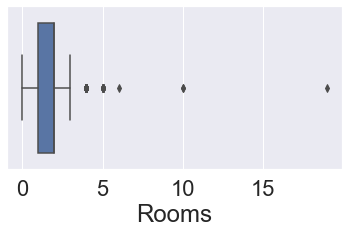

In [1874]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

In [1875]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [1876]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.718750,0


#### Заменяем отсутствие квартир на 1, а более или равно 6 квартир на медиану

In [1877]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [1878]:
# train_df['Rooms'].value_counts()

#### KitchenSquare - площадь кухни

In [1879]:
# train_df['KitchenSquare'].value_counts()

In [1880]:
train_df['KitchenSquare'].quantile(.98), train_df['KitchenSquare'].quantile(.02)

(13.0, 0.0)

#### Заменяем все кухни из выборки от 0 до 2,5% и более 97,5% - медианой, а после кухни, площадью менее 4 м2 - на 4 м2 (вряд ли есть кухни менее 4 м2)

In [1881]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.98))
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

In [1882]:
train_df['KitchenSquare'].value_counts()

4.0     3222
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

#### Square - площадь

In [1883]:
train_df['Square'].value_counts()

37.498161    2
65.285133    2
80.794792    2
44.482914    2
81.867165    2
            ..
63.952770    1
39.010426    1
66.681969    1
72.683846    1
35.815475    1
Name: Square, Length: 9995, dtype: int64

In [1884]:
train_df['Square'].quantile(.98), train_df['Square'].quantile(.02)

(103.62241653442385, 31.53776779174805)

In [1885]:
condition = ((train_df['Square'] < train_df['Square'].quantile(.02)) \
             | (train_df['Square'] > train_df['Square'].quantile(.98)))
train_df.loc[condition, 'Square'] = train_df['Square'].median()

In [1886]:
train_df['Square'].value_counts()

52.513309    400
80.794792      2
37.498161      2
44.482914      2
81.867165      2
            ... 
65.818504      1
65.688759      1
47.994453      1
57.267155      1
35.815475      1
Name: Square, Length: 9596, dtype: int64

In [1887]:
train_df['Square'].min()

31.53826

#### Пропуски признака LifeSquare заполним данными, полученных вычитанием из общей площади Square площади кухни KitchenSquare минус 3

In [1888]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1
# train_df.head(3)

In [1889]:
condition = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna()) & (~train_df['KitchenSquare'].isna())
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3
# train_df.head(3)

#### Floor - этаж
#### HouseFloor - количество этажей в доме

In [1890]:
# train_df['HouseFloor'].value_counts()

In [1891]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1
# train_df

In [1892]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [1893]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
# floor_outliers

In [1894]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [1895]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

In [1896]:
# plt.figure(figsize = (10, 4))

# train_df['Floor'].hist(bins=30)
# plt.ylabel('Count')
# # plt.yscale(value="log")
# plt.xlabel('Floor')

# plt.title('Floor')
# plt.show()

In [1897]:
# train_df[['Floor', 'HouseFloor']].value_counts()

#### HouseYear - год постройки дома

In [1898]:
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1910           1
1916           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [1899]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021

In [1900]:
(train_df['HouseYear'] > 2021).sum()

0

#### Итоговый класс для подготовки данных

In [1901]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.98)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 4, 'KitchenSquare'] = 4
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year   
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

#### Смотрим корреляционную матрицу - ищем зависимости признаков друг от друга

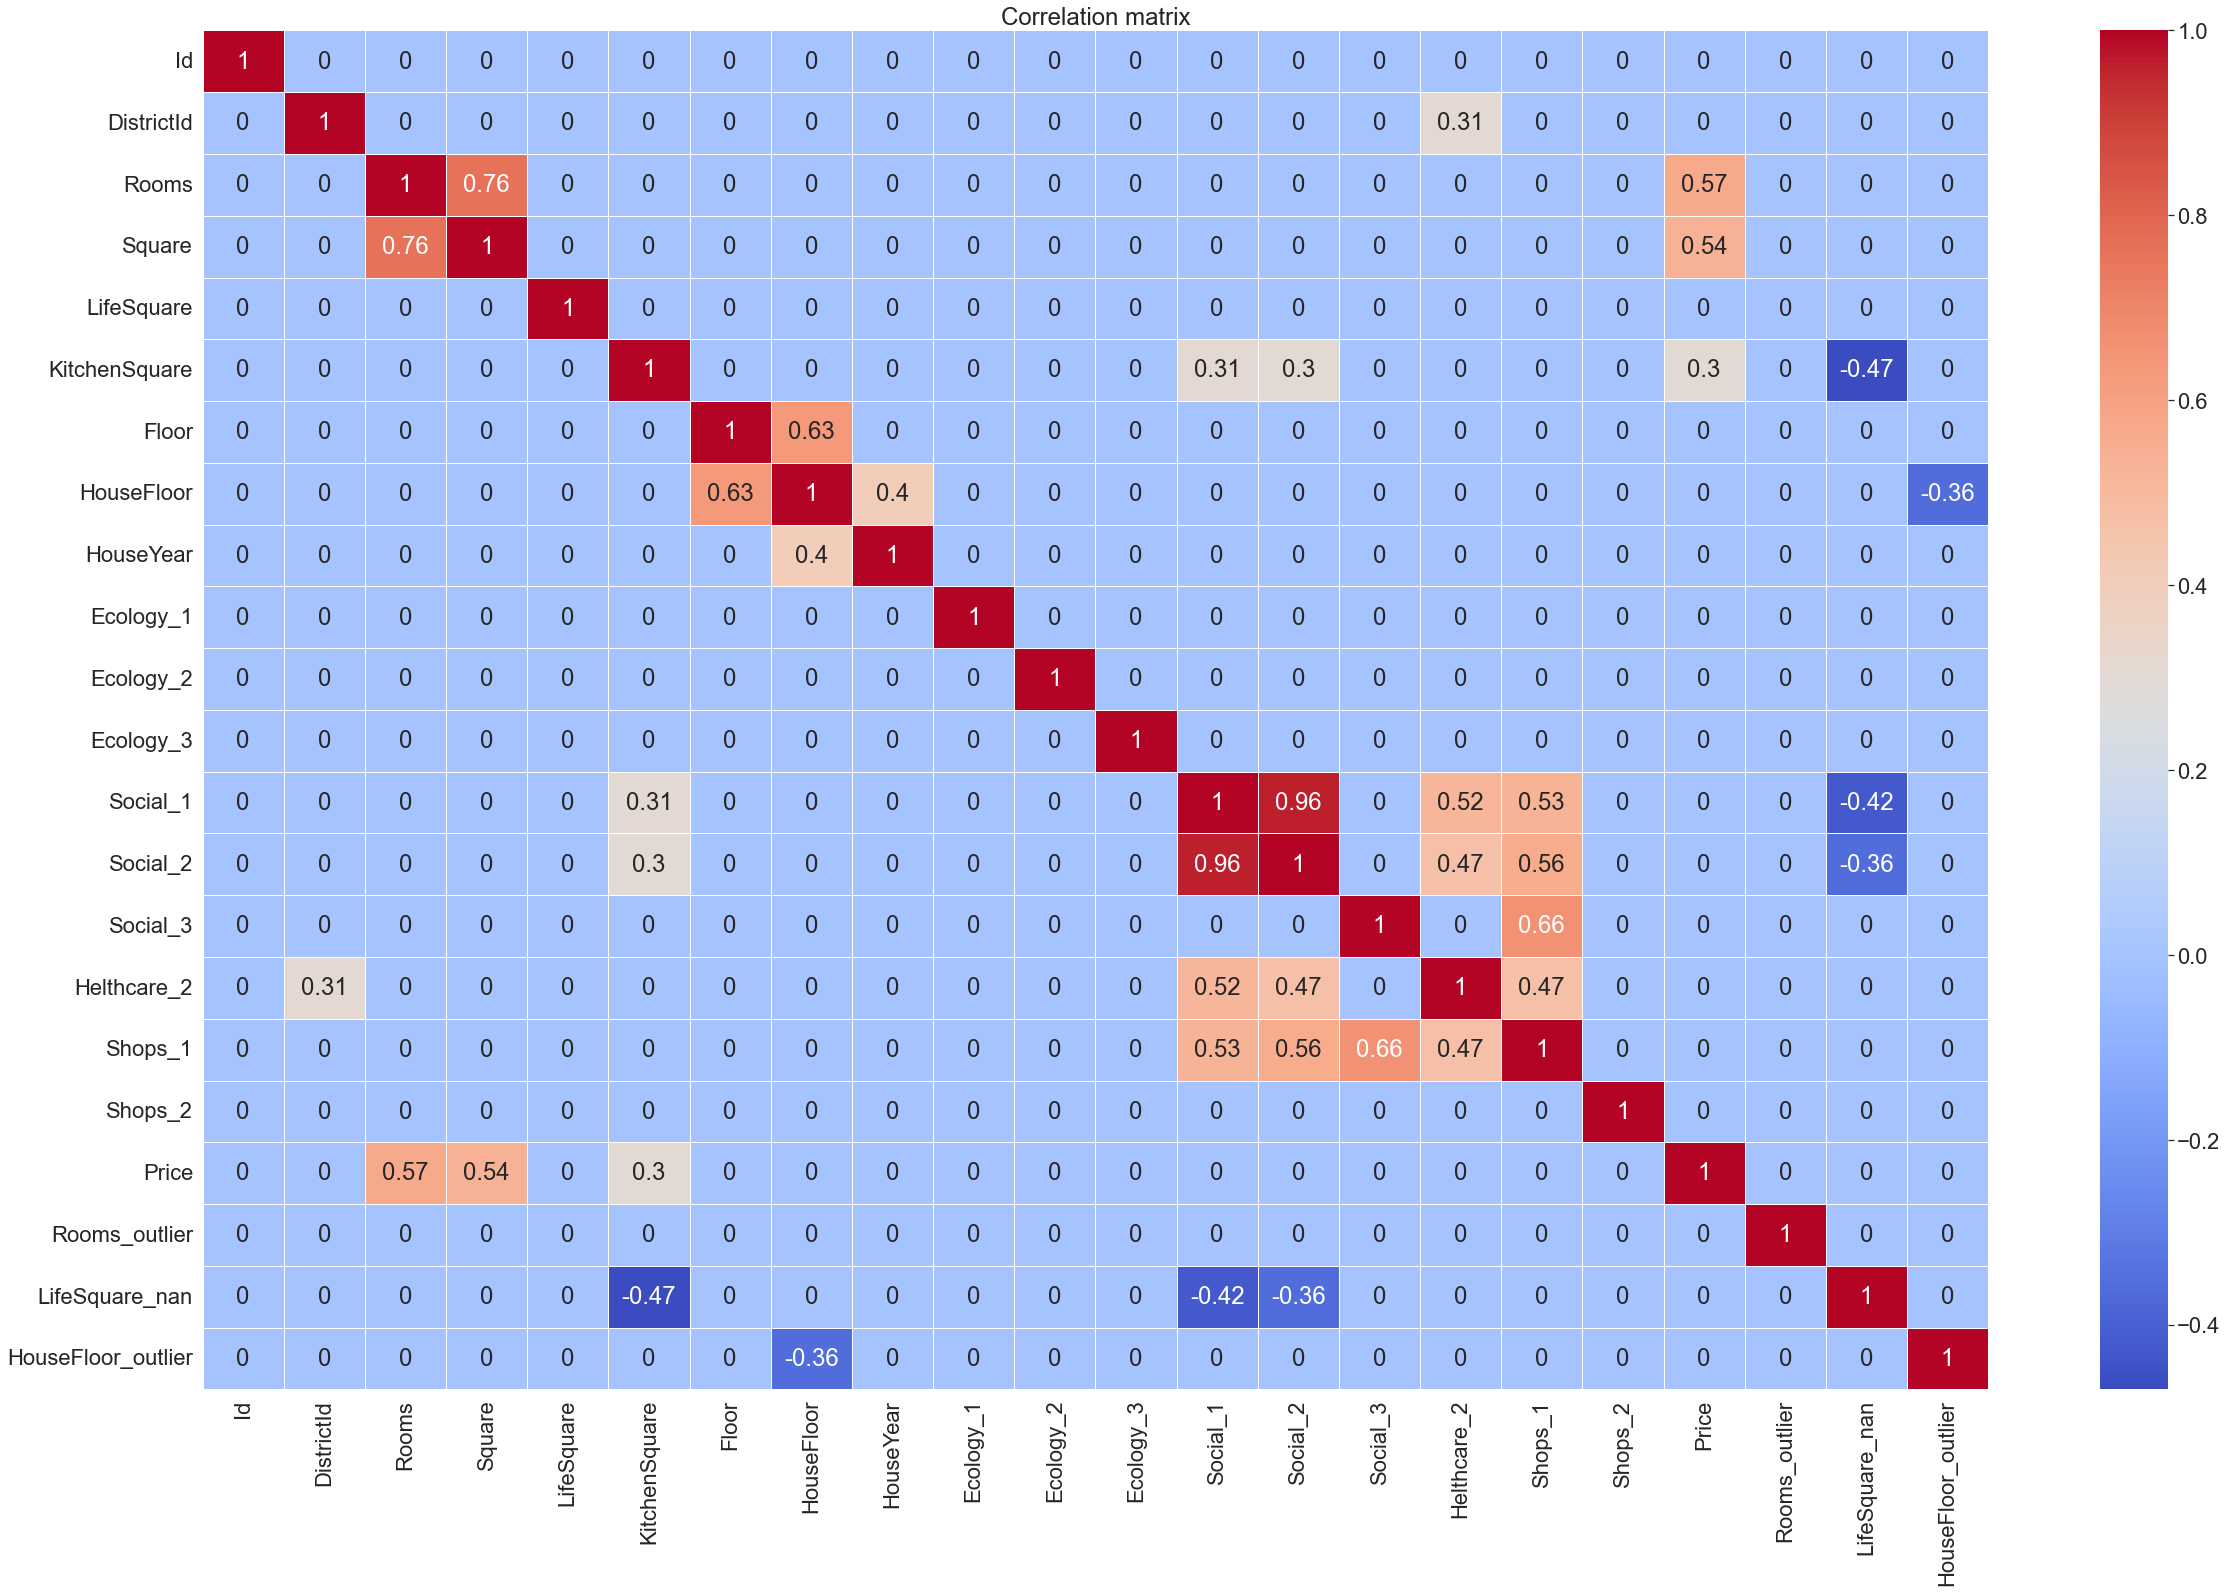

In [1902]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

#### И зависимости цели (цены) от признаков

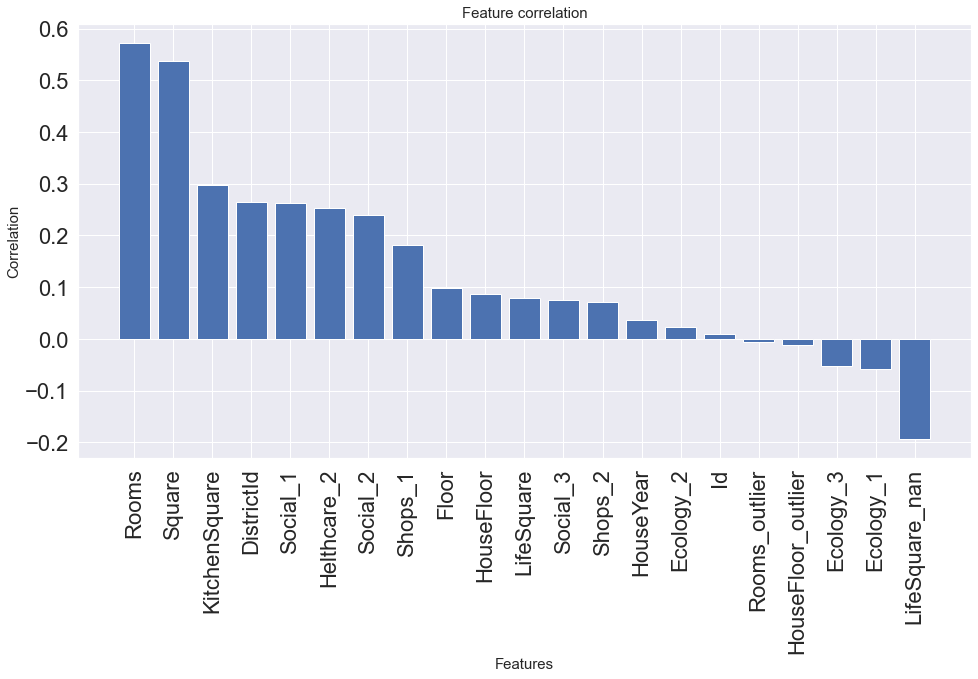

In [1903]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()